In [1]:
from collections import Counter
from representations.utils import *
import pandas as pd
import numpy as np
from scipy import sparse, stats
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler
import numba
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# np.set_printoptions(suppress=True)

In [2]:
def get_unigrams_sorted(corpus, min_count=5):
    unigram_counts = Counter()
    for ii, sent in enumerate(corpus):
        if ii % 200000 == 0:
            print(f'finished {ii/len(corpus):.2%} of corpus')
        for token in sent:
            unigram_counts[token] += 1
    unigram_counts = {k:v for k,v in unigram_counts.items() if v >= min_count}                
    return unigram_counts

In [3]:
slice_1 = list(CreateSlice('reichstag/rt_slice_1_processed'))
slice_2 = list(CreateSlice('reichstag/rt_slice_2_processed'))
slice_3 = list(CreateSlice('reichstag/rt_slice_3_processed'))
slice_4 = list(CreateSlice('reichstag/rt_slice_4_processed'))
slice_5 = list(CreateSlice('reichstag/rt_slice_5_processed'))

In [4]:
ns_period = list(CreateSlice('reichstag/ns_processed'))

In [5]:
len(ns_period)

19127

In [4]:
unigrams_slice_1 = get_unigrams_sorted(slice_1, min_count=5)
targets_slice_1 = create_target_sets(unigrams_slice_1, kind='RT')
attributes_slice_1 = create_attribute_sets(unigrams_slice_1, kind='RT')

unigrams_slice_2 = get_unigrams_sorted(slice_2, min_count=5)
targets_slice_2 = create_target_sets(unigrams_slice_2, kind='RT')
attributes_slice_2 = create_attribute_sets(unigrams_slice_2, kind='RT')

unigrams_slice_3 = get_unigrams_sorted(slice_2, min_count=5)
targets_slice_3 = create_target_sets(unigrams_slice_3, kind='RT')
attributes_slice_3 = create_attribute_sets(unigrams_slice_3, kind='RT')

unigrams_slice_4 = get_unigrams_sorted(slice_4, min_count=5)
targets_slice_4 = create_target_sets(unigrams_slice_4, kind='RT')
attributes_slice_4 = create_attribute_sets(unigrams_slice_4, kind='RT')

unigrams_slice_5 = get_unigrams_sorted(slice_5, min_count=5)
targets_slice_5 = create_target_sets(unigrams_slice_5, kind='RT')
attributes_slice_5 = create_attribute_sets(unigrams_slice_5, kind='RT')

finished 0.00% of corpus
finished 15.18% of corpus
finished 30.36% of corpus
finished 45.54% of corpus
finished 60.72% of corpus
finished 75.90% of corpus
finished 91.08% of corpus
finished 0.00% of corpus
finished 15.11% of corpus
finished 30.22% of corpus
finished 45.33% of corpus
finished 60.44% of corpus
finished 75.55% of corpus
finished 90.66% of corpus
finished 0.00% of corpus
finished 15.11% of corpus
finished 30.22% of corpus
finished 45.33% of corpus
finished 60.44% of corpus
finished 75.55% of corpus
finished 90.66% of corpus
finished 0.00% of corpus
finished 9.56% of corpus
finished 19.12% of corpus
finished 28.68% of corpus
finished 38.25% of corpus
finished 47.81% of corpus
finished 57.37% of corpus
finished 66.93% of corpus
finished 76.49% of corpus
finished 86.05% of corpus
finished 95.61% of corpus
finished 0.00% of corpus
finished 10.39% of corpus
finished 20.77% of corpus
finished 31.16% of corpus
finished 41.55% of corpus
finished 51.94% of corpus
finished 62.32% of

In [9]:
def get_indices(unigram_counts, targets_1, targets_2, attributes_1, attributes_2):
    all_words = targets_1 + targets_2 + attributes_1 + attributes_2
    tok2indx = {tok: indx for indx, tok in enumerate(all_words)}
    j = len(all_words)
    print(j)
    for tok in unigram_counts.keys():
        if tok not in all_words:
            tok2indx[tok] = j
            j += 1
    indx2tok = {indx: tok for tok,indx in tok2indx.items()}
    print('done')
    print('vocabulary size: {}'.format(len(tok2indx)))
    return tok2indx, indx2tok

In [6]:
t2i_slice_1, i2t_slice_1 = get_indices(unigrams_slice_1, attributes_slice_1['pleasant'], attributes_slice_1['unpleasant'],
                                       targets_slice_1['jewish'],  targets_slice_1['christian'])
t2i_slice_2, i2t_slice_2 = get_indices(unigrams_slice_2, attributes_slice_2['pleasant'], attributes_slice_2['unpleasant'],
                                       targets_slice_2['jewish'],  targets_slice_2['christian'])
t2i_slice_3, i2t_slice_3 = get_indices(unigrams_slice_3, attributes_slice_3['pleasant'], attributes_slice_3['unpleasant'],
                                       targets_slice_3['jewish'],  targets_slice_3['christian'])
t2i_slice_4, i2t_slice_4 = get_indices(unigrams_slice_4, attributes_slice_4['pleasant'], attributes_slice_4['unpleasant'],
                                       targets_slice_4['jewish'],  targets_slice_4['christian'])
t2i_slice_5, i2t_slice_5 = get_indices(unigrams_slice_5, attributes_slice_5['pleasant'], attributes_slice_5['unpleasant'],
                                       targets_slice_5['jewish'],  targets_slice_5['christian'])

64
done
vocabulary size: 56128
66
done
vocabulary size: 54314
66
done
vocabulary size: 54314
73
done
vocabulary size: 73067
70
done
vocabulary size: 67285


In [10]:
def get_skipgram_counts(corpus, tok2indx, indx2tok):
    skipgram_counts = Counter()

    for ix, sent in enumerate(corpus):
        tokens = [tok2indx[tok] for tok in sent if tok in tok2indx]
        for ii_word, word in enumerate(tokens):
            ii_contexts = [
                ii for ii in range(len(tokens)) 
                if ii != ii_word]
            for ii_context in ii_contexts:
                skipgram = (tokens[ii_word], tokens[ii_context])
                skipgram_counts[skipgram] += 1    
        if ix % 200000 == 0:
            print(f'finished {ix/len(corpus):.2%} of corpus')

    print('done')
    print('number of skipgrams: {}'.format(len(skipgram_counts)))
    most_common = [
        (indx2tok[sg[0][0]], indx2tok[sg[0][1]], sg[1]) 
        for sg in skipgram_counts.most_common(10)]
    print('most common: {}'.format(most_common))
    return skipgram_counts

In [11]:
def create_coo_mat(skipgram_counts):
    row_indxs = []
    col_indxs = []
    dat_values = []
    ii = 0
    for (tok1, tok2), sg_count in skipgram_counts.items():
        ii += 1
        if ii % 1000000 == 0:
            print(f'finished {ii/len(skipgram_counts):.2%} of skipgrams')    
        row_indxs.append(tok1)
        col_indxs.append(tok2)
        dat_values.append(sg_count)
    wwcnt_mat = sparse.csr_matrix((dat_values, (row_indxs, col_indxs)))
    return wwcnt_mat

In [113]:
# coo_mat_slice_1= create_coo_mat(skipgrams_slice_1)
coo_mat_slice_2= create_coo_mat(skipgrams_slice_2)

finished 2.09% of skipgrams
finished 4.18% of skipgrams
finished 6.26% of skipgrams
finished 8.35% of skipgrams
finished 10.44% of skipgrams
finished 12.53% of skipgrams
finished 14.61% of skipgrams
finished 16.70% of skipgrams
finished 18.79% of skipgrams
finished 20.88% of skipgrams
finished 22.96% of skipgrams
finished 25.05% of skipgrams
finished 27.14% of skipgrams
finished 29.23% of skipgrams
finished 31.31% of skipgrams
finished 33.40% of skipgrams
finished 35.49% of skipgrams
finished 37.58% of skipgrams
finished 39.66% of skipgrams
finished 41.75% of skipgrams
finished 43.84% of skipgrams
finished 45.93% of skipgrams
finished 48.01% of skipgrams
finished 50.10% of skipgrams
finished 52.19% of skipgrams
finished 54.28% of skipgrams
finished 56.36% of skipgrams
finished 58.45% of skipgrams
finished 60.54% of skipgrams
finished 62.63% of skipgrams
finished 64.71% of skipgrams
finished 66.80% of skipgrams
finished 68.89% of skipgrams
finished 70.98% of skipgrams
finished 73.06% of

In [12]:
def create_ppmi_mat(coo_mat, skipgram_counts):  
    num_skipgrams = coo_mat.sum()
#     assert(sum(skipgram_counts.values())==num_skipgrams)

    # for creating sparce matrices
    row_indxs = []
    col_indxs = []

#     pmi_dat_values = []    # pointwise mutual information
    ppmi_dat_values = []   # positive pointwise mutial information
#     spmi_dat_values = []   # smoothed pointwise mutual information
#     npmi_dat_values = []
#     pnpmi_dat_values = []
    sppmi_dat_values = []  # smoothed positive pointwise mutual information

    sum_over_words = np.array(coo_mat.sum(axis=0)).flatten()
    sum_over_contexts = np.array(coo_mat.sum(axis=1)).flatten()

    # smoothing
    alpha = 0.75
    sum_over_words_alpha = sum_over_words**alpha
    nca_denom = np.sum(sum_over_words_alpha)

    ii = 0
    for (tok_word, tok_context), sg_count in skipgram_counts.items():
        ii += 1
        if ii % 1000000 == 0:
            print(f'finished {ii/len(skipgram_counts):.2%} of skipgrams')

        nwc = sg_count
        Pwc = nwc / num_skipgrams
        nw = sum_over_contexts[tok_word]
        Pw = nw / num_skipgrams
        nc = sum_over_words[tok_context]
        Pc = nc / num_skipgrams

        nca = sum_over_words_alpha[tok_context] # Give	rare	words	slightly	higher	probabilities
        Pca = nca / nca_denom

        # note 
        # pmi = log {#(w,c) |D| / [#(w) #(c)]} 
        #     = log {nwc * num_skipgrams / [nw nc]}
        #     = log {P(w,c) / [P(w) P(c)]} 
        #     = log {Pwc / [Pw Pc]}


        pmi = np.log2(Pwc/(Pw*Pc))   
#         npmi = pmi / -np.log2(Pwc)
#         pnpmi = max(npmi, 0) 
        ppmi = max(pmi, 0)
        spmi = np.log2(Pwc/(Pw*Pca))
        sppmi = max(spmi, 0)

        row_indxs.append(tok_word)
        col_indxs.append(tok_context)
        
#         pmi_dat_values.append(pmi)
        ppmi_dat_values.append(ppmi)
#         spmi_dat_values.append(spmi)
        sppmi_dat_values.append(sppmi)
#         npmi_dat_values.append(npmi)
#         pnpmi_dat_values.append(pnpmi)

    ppmi_mat = sparse.csr_matrix((ppmi_dat_values, (row_indxs, col_indxs)))
#     spmi_mat = sparse.csr_matrix((spmi_dat_values, (row_indxs, col_indxs)))
    sppmi_mat = sparse.csr_matrix((sppmi_dat_values, (row_indxs, col_indxs)))
#     pnpmi_mat = sparse.csr_matrix((pnpmi_dat_values, (row_indxs, col_indxs)))
#     npmi_mat = sparse.csr_matrix((npmi_dat_values, (row_indxs, col_indxs)))
    
    return ppmi_mat, sppmi_mat

In [114]:
ppmi_slice_2, sppmi_slice_2, nppmi_slice_2, npmi_slice_2 = create_ppmi_mat(coo_mat_slice_2, skipgrams_slice_2)

finished 2.09% of skipgrams
finished 4.18% of skipgrams
finished 6.26% of skipgrams
finished 8.35% of skipgrams
finished 10.44% of skipgrams
finished 12.53% of skipgrams
finished 14.61% of skipgrams
finished 16.70% of skipgrams
finished 18.79% of skipgrams
finished 20.88% of skipgrams
finished 22.96% of skipgrams
finished 25.05% of skipgrams
finished 27.14% of skipgrams
finished 29.23% of skipgrams
finished 31.31% of skipgrams
finished 33.40% of skipgrams
finished 35.49% of skipgrams
finished 37.58% of skipgrams
finished 39.66% of skipgrams
finished 41.75% of skipgrams
finished 43.84% of skipgrams
finished 45.93% of skipgrams
finished 48.01% of skipgrams
finished 50.10% of skipgrams
finished 52.19% of skipgrams
finished 54.28% of skipgrams
finished 56.36% of skipgrams
finished 58.45% of skipgrams
finished 60.54% of skipgrams
finished 62.63% of skipgrams
finished 64.71% of skipgrams
finished 66.80% of skipgrams
finished 68.89% of skipgrams
finished 70.98% of skipgrams
finished 73.06% of

In [4]:
# slice_2 = list(CreateSlice('reichstag/rt_slice_2_processed'))
# t2i_slice_2, i2t_slice_2 = get_unigrams(slice_2)
# skipgrams_slice_2 = get_skipgram_counts(slice_2,t2i_slice_2, i2t_slice_2)
# coo_mat_slice_2 = create_coo_mat(skipgrams_slice_2)
# ppmi_slice_2, sppmi_slice_2 = create_ppmi_mat(coo_mat_slice_2, skipgrams_slice_2)

# sparse.save_npz('ppmi_slice_2', ppmi_slice_2, compressed=True)
# sparse.save_npz('sppmi_slice_2', sppmi_slice_2, compressed=True)

# slice_3 = list(CreateSlice('reichstag/rt_slice_3_processed'))
# t2i_slice_3, i2t_slice_3 = get_unigrams(slice_3)
# skipgrams_slice_3 = get_skipgram_counts(slice_3,t2i_slice_3, i2t_slice_3)
# coo_mat_slice_3 = create_coo_mat(skipgrams_slice_3)
# ppmi_slice_3, sppmi_slice_3 = create_ppmi_mat(coo_mat_slice_3, skipgrams_slice_3)

# sparse.save_npz('ppmi_slice_3', ppmi_slice_3, compressed=True)
# sparse.save_npz('sppmi_slice_3', sppmi_slice_3, compressed=True)

# slice_4 = list(CreateSlice('reichstag/rt_slice_4_processed'))
# t2i_slice_4, i2t_slice_4 = get_unigrams(slice_4)
# skipgrams_slice_4 = get_skipgram_counts(slice_4,t2i_slice_4, i2t_slice_4)
# coo_mat_slice_4 = create_coo_mat(skipgrams_slice_4)
# ppmi_slice_4, sppmi_slice_4 = create_ppmi_mat(coo_mat_slice_4, skipgrams_slice_4)

# sparse.save_npz('ppmi_slice_4', ppmi_slice_4, compressed=True)
# sparse.save_npz('sppmi_slice_4', sppmi_slice_4, compressed=True)

# slice_5 = list(CreateSlice('reichstag/rt_slice_5_processed'))
# t2i_slice_5, i2t_slice_5 = get_unigrams(slice_5)
# skipgrams_slice_5 = get_skipgram_counts(slice_5,t2i_slice_5, i2t_slice_5)
# coo_mat_slice_5 = create_coo_mat(skipgrams_slice_5)
# ppmi_slice_5, sppmi_slice_5 = create_ppmi_mat(coo_mat_slice_5, skipgrams_slice_5)

# sparse.save_npz('ppmi_slice_5', ppmi_slice_5, compressed=True)
# sparse.save_npz('sppmi_slice_5', sppmi_slice_5, compressed=True)

finished 0.00% of corpus
finished 15.11% of corpus
finished 30.22% of corpus
finished 45.33% of corpus
finished 60.44% of corpus
finished 75.55% of corpus
finished 90.66% of corpus
done
vocabulary size: 54314


NameError: name 'get_skipgram_counts' is not defined

### Pipeline

In [14]:
def pipeline(path, att_1, att_2, kind, label):
    sentences = list(CreateSlice(path))
    unigrams = get_unigrams_sorted(sentences)
    targets = create_target_sets(unigrams, kind=kind)
    attributes = create_attribute_sets(unigrams, kind=kind)
    
    tok2indx, indx2tok = get_indices(unigrams, attributes[att_1], attributes[att_2],
                                       targets['jewish'],  targets['christian'])
    skipgrams = get_skipgram_counts(sentences, tok2indx, indx2tok)
    coo_mat = create_coo_mat(skipgrams)
    ppmi_mat, sppmi_mat = create_ppmi_mat(coo_mat, skipgrams)
    sparse.save_npz(f'matrices/ppmi_slice_{label}.npz', ppmi_mat, compressed=True)
    sparse.save_npz(f'matrices/sppmi_slice_{label}.npz', sppmi_mat, compressed=True)
    
    return ppmi_mat, sppmi_mat, tok2indx, indx2tok, targets, attributes

In [15]:
ppmi_ns, sppmi_ns, t2i_ns, i2t_ns, targets_ns, attributes_ns = pipeline(
    'reichstag/ns_processed', 'pleasant', 'unpleasant', 'RT', 'ns')

finished 0.00% of corpus
26
done
vocabulary size: 4690
finished 0.00% of corpus
done
number of skipgrams: 1035739
most common: [('der', 'der', 80016), ('der', 'und', 21177), ('und', 'der', 21177), ('der', 'sein', 15725), ('sein', 'der', 15725), ('ein', 'der', 14447), ('der', 'ein', 14447), ('0', '0', 13410), ('in', 'der', 13153), ('der', 'in', 13153)]
finished 96.55% of skipgrams
finished 96.55% of skipgrams


In [188]:
ppmi_slice_1, sppmi_slice_1, t2i_slice_1, i2t_slice_1, targets_slice_1, attributes_slice_1 = pipeline(
    'reichstag/rt_slice_1_processed', 'volkstreu', 'volksuntreu', 5, 'RT', 1)

ppmi_slice_2, sppmi_slice_2, t2i_slice_2, i2t_slice_2, targets_slice_2, attributes_slice_2 = pipeline(
    'reichstag/rt_slice_2_processed', 'volkstreu', 'volksuntreu', 5, 'RT', 2)


ppmi_slice_3, sppmi_slice_3, t2i_slice_3, i2t_slice_3, targets_slice_3, attributes_slice_3 = pipeline(
    'reichstag/rt_slice_3_processed', 'volkstreu', 'volksuntreu', 5, 'RT', 3)


ppmi_slice_4, sppmi_slice_4, t2i_slice_4, i2t_slice_4, targets_slice_4, attributes_slice_4 = pipeline(
    'reichstag/rt_slice_4_processed', 'volkstreu', 'volksuntreu', 5, 'RT', 4)


ppmi_slice_5, sppmi_slice_5, t2i_slice_5, i2t_slice_5, targets_slice_5, attributes_slice_5 = pipeline(
    'reichstag/rt_slice_5_processed', 'volkstreu', 'volksuntreu', 5, 'RT', 5)


finished 0.00% of corpus
finished 15.18% of corpus
finished 30.36% of corpus
finished 45.54% of corpus
finished 60.72% of corpus
finished 75.90% of corpus
finished 91.08% of corpus
47
done
vocabulary size: 56128
finished 0.00% of corpus
finished 15.18% of corpus
finished 30.36% of corpus
finished 45.54% of corpus
finished 60.72% of corpus
finished 75.90% of corpus
finished 91.08% of corpus
done
number of skipgrams: 50297633
most common: [('der', 'der', 14708094), ('der', 'sein', 3418153), ('sein', 'der', 3418153), ('der', 'und', 2878798), ('und', 'der', 2878798), ('in', 'der', 2498106), ('der', 'in', 2498106), ('der', 'ein', 2337427), ('ein', 'der', 2337427), ('der', 'werden', 2124211)]
finished 1.99% of skipgrams
finished 3.98% of skipgrams
finished 5.96% of skipgrams
finished 7.95% of skipgrams
finished 9.94% of skipgrams
finished 11.93% of skipgrams
finished 13.92% of skipgrams
finished 15.91% of skipgrams
finished 17.89% of skipgrams
finished 19.88% of skipgrams
finished 21.87% of 

KeyboardInterrupt: 

## Load matrices

In [1]:
ppmi_slice_1 = sparse.load_npz('matrices/ppmi_slice_1.npz')
# ppmi_slice_2 = sparse.load_npz('matrices/ppmi_slice_2.npz')
# ppmi_slice_3 = sparse.load_npz('matrices/ppmi_slice_3.npz')
# ppmi_slice_4 = sparse.load_npz('matrices/ppmi_slice_4.npz')
# ppmi_slice_5 = sparse.load_npz('matrices/ppmi_slice_5.npz')

NameError: name 'sparse' is not defined

In [189]:
!ls matrices

npmi_slice_1.npz	   ppmi_slice_3_mc15.npz	sppmi_slice_2_full.npz
npmi_slice_2_full.npz	   ppmi_slice_3_mc20.npz	sppmi_slice_2_mc15.npz
npmi_slice_2.npz	   ppmi_slice_3.npz		sppmi_slice_2_mc20.npz
nppmi_slice_1.npz	   ppmi_slice_4_mc15.npz	sppmi_slice_3_mc15.npz
nppmi_slice_2_full.npz	   ppmi_slice_4_mc20.npz	sppmi_slice_3_mc20.npz
nppmi_slice_2.npz	   ppmi_slice_4.npz		sppmi_slice_3.npz
ppmi_slice_1_mc15.npz	   ppmi_slice_5_mc15.npz	sppmi_slice_4_mc15.npz
ppmi_slice_1_mc20.npz	   ppmi_slice_5_mc20.npz	sppmi_slice_4_mc20.npz
ppmi_slice_1_mc5_set2.npz  ppmi_slice_5.npz		sppmi_slice_4.npz
ppmi_slice_1.npz	   sppmi_slice_1_mc15.npz	sppmi_slice_5_mc15.npz
ppmi_slice_2_mc15.npz	   sppmi_slice_1_mc20.npz	sppmi_slice_5_mc20.npz
ppmi_slice_2_mc20.npz	   sppmi_slice_1_mc5_sett2.npz	sppmi_slice_5.npz
ppmi_slice_2.npz	   sppmi_slice_1.npz


In [17]:
# Tested this method --> works fine
def reindex(matrix, t2i, attributes):
    matrix = matrix.toarray()
    pos_indices_to_swap = [t2i[word] for word in attributes['volkstreu']]
    neg_indices_to_swap = [t2i[word] for word in attributes['volksuntreu']]
    
    for indx_old, indx_new in enumerate(pos_indices_to_swap):
        matrix[[indx_old, indx_new]] = matrix[[indx_new, indx_old]]
        matrix[:,[indx_old, indx_new]] = matrix[:,[indx_new, indx_old]]

    for indx_old, indx_new in enumerate(neg_indices_to_swap):
        matrix[[indx_old+len(pos_indices_to_swap), indx_new]] = matrix[[indx_new, indx_old+len(pos_indices_to_swap)]]
        matrix[:,[indx_old+len(pos_indices_to_swap), indx_new]] = matrix[:,[indx_new, indx_old+len(pos_indices_to_swap)]]
    
    return sparse.csr_matrix(matrix)

In [20]:
ppmi_mat_slice_1_reindexed = reindex(ppmi_slice_1, t2i_slice_1, attributes_slice_1)

In [19]:
ppmi_mat_slice_2_reindexed = reindex(ppmi_slice_2, t2i_slice_2, attributes_slice_2)
ppmi_mat_slice_3_reindexed = reindex(ppmi_slice_3, t2i_slice_3, attributes_slice_3)
ppmi_mat_slice_4_reindexed = reindex(ppmi_slice_4, t2i_slice_4, attributes_slice_4)
ppmi_mat_slice_5_reindexed = reindex(ppmi_slice_5, t2i_slice_5, attributes_slice_5)

MemoryError: Unable to allocate 30.8 GiB for an array with shape (64336, 64336) and data type float64

#### Dive a little into non-zero entries

In [18]:
def matrix_stats(mat):
    print(f'Maximum value: {mat.max()}')
#     print(f'Minimum value: {mat.min()}')

def non_zero_stats(mat):
    ppmi_vals = mat.toarray().flatten() 
    ppmi_nonzero = ppmi_vals[ppmi_vals!=0]
    print(f'Mean of non-zero entries: {ppmi_nonzero.mean()}')
    print(f'Std of non-zero entries: {ppmi_nonzero.std()}')
    print(f'Lower quantile of non-zero entries: {np.percentile(ppmi_nonzero, 25)}')
    print(f'Median of non-zero entries: {np.percentile(ppmi_nonzero, 50)}')
    print(f'Upper quantile of non-zero entries: {np.percentile(ppmi_nonzero, 75)}')

def get_nonzero_percentage(ppmi_mat):
    '''ComputePercentage of elements that are non-zero'''
    print(ppmi_mat.count_nonzero() / ppmi_mat.shape[0]**2)

In [38]:
get_nonzero_percentage(ppmi_mat_slice_1_reindexed)
get_nonzero_percentage(ppmi_mat_slice_2_reindexed)
get_nonzero_percentage(ppmi_mat_slice_3_reindexed)
get_nonzero_percentage(ppmi_mat_slice_4_reindexed)
get_nonzero_percentage(ppmi_mat_slice_5_reindexed)

AttributeError: 'numpy.ndarray' object has no attribute 'count_nonzero'

### Harmonic function label propagation

In [19]:
# Add small number as noise to make matrix non-singular
M = 1e-06

In [20]:
@numba.jit
def inverse(A):
  return np.linalg.inv(A)

def create_labels(targets_1, targets_2):
    labels = []
    for word in targets_1:
        labels.append(1)
    for word in targets_2:
        labels.append(0)
    labels = np.array(labels)
    return labels

In [23]:
labels_1 = create_labels(attributes_slice_1['volkstreu'], attributes_slice_1['volksuntreu'])
labels_2 = create_labels(attributes_slice_2['volkstreu'], attributes_slice_2['volksuntreu'])
labels_3 = create_labels(attributes_slice_3['volkstreu'], attributes_slice_3['volksuntreu'])
labels_4 = create_labels(attributes_slice_4['volkstreu'], attributes_slice_4['volksuntreu'])
labels_5 = create_labels(attributes_slice_5['volkstreu'], attributes_slice_5['volksuntreu'])

In [21]:
labels_ns = create_labels(attributes_ns['pleasant'], attributes_ns['unpleasant'])

In [23]:
def propagate_labels(ppmi_mat, labels, label):
    # Compute normalized laplacian 
    L = sparse.csgraph.laplacian(ppmi_mat, normed=True).toarray()
    
    # Sub-matrices L_ul and L_uu
    L_ul = L[len(labels):, :len(labels)]
    L_uu = L[len(labels):, len(labels):]
    
    # Compute scores fu (add a little bit if noise to L_uu to avoid LinAlgError when computing inverse)
    fu = (-1* inverse(L_uu + np.eye(L_uu.shape[0])*M)).dot(L_ul).dot(labels)
    np.save(f'fu_scores/{label}', fu)
    return fu  

In [24]:
fu_ns = propagate_labels(ppmi_ns, labels_ns, 'ns')

In [205]:
fu_2 = propagate_labels(ppmi_slice_2, labels_2,2)

In [226]:
fu_3 = propagate_labels(ppmi_slice_3, labels_3,3, 5)

In [227]:
fu_4 = propagate_labels(ppmi_slice_4, labels_4,4, 5)

In [128]:
fu_5 = propagate_labels(ppmi_slice_5, labels_5,5,5)

In [26]:
    def bias_term_indices(tok2indx, labels, targets):
         return {k: [tok2indx[word] - len(labels) for word in v] for k,v in targets.items()}

In [27]:
bias_term_indices_ns = bias_term_indices(t2i_ns, labels_ns, targets_ns)

In [63]:
bias_term_indices_1 = bias_term_indices(t2i_slice_1, labels_1, targets_slice_1)
bias_term_indices_2 = bias_term_indices(t2i_slice_2, labels_2, targets_slice_2)
bias_term_indices_3 = bias_term_indices(t2i_slice_3, labels_3, targets_slice_3)
bias_term_indices_4 = bias_term_indices(t2i_slice_4, labels_4, targets_slice_4)
bias_term_indices_5 = bias_term_indices(t2i_slice_5, labels_5, targets_slice_5)

In [29]:
def get_bias_term_scores(fu_scores, bias_term_indices):
    return {k: fu_scores[v] for k,v in bias_term_indices.items()}

In [30]:
scores_ns = get_bias_term_scores(fu_ns, bias_term_indices_ns)

In [118]:
scores_1 = get_bias_term_scores(fu_1, bias_term_indices_1)
scores_2 = get_bias_term_scores(fu_2, bias_term_indices_2)
scores_3 = get_bias_term_scores(fu_3, bias_term_indices_3)
scores_4 = get_bias_term_scores(fu_4, bias_term_indices_4)
scores_5 = get_bias_term_scores(fu_5, bias_term_indices_5)

In [62]:
fu_1 = np.load('fu_scores/1_mc5.npy')
fu_2 = np.load('fu_scores/2_mc5.npy')
fu_3 = np.load('fu_scores/3_mc5.npy')
fu_4 = np.load('fu_scores/4_mc5.npy')
fu_5 = np.load('fu_scores/5_mc5.npy')

In [31]:
def score_df(targets, scores):
    return pd.DataFrame(index = np.concatenate([v for v in targets.values()]),
                        data = np.concatenate([v for v in scores.values()]),
                        columns = ['f_score'])

In [35]:
score_df(targets_ns, scores_ns)
to_csv('fu_scores_slice_1_mc5')

,f_score
jude,0.305826
juedisch,0.385313
judentum,0.322159
christlich,0.329109
evangelisch,0.257543
kirche,0.353970
pfarrer,0.336246
zentrumspartei,0.308815
evangelisch,0.257543


In [117]:
score_df(targets_slice_1, fu_scores_1)

,f_score
jude,0.461696
juedisch,0.383697
judentum,0.161652
orthodox,0.269521
israel,0.130545
mosaisch,0.195359
israelitisch,0.288243
israelit,0.286249
rothschild,0.388362
synagoge,0.176947


In [159]:
scores_slice_1 = score_df(targets_slice_1, fu_scores_1)
scores_slice_1.to_csv('fu_scores_slice_1_mc5')

scores_slice_2 = score_df(targets_slice_2, fu_scores_2)
scores_slice_2.to_csv('fu_scores_slice_2_mc5')

scores_slice_3 = score_df(targets_slice_3, fu_scores_3)
scores_slice_3.to_csv('fu_scores_slice_3_mc5')

scores_slice_4 = score_df(targets_slice_4, fu_scores_4)
scores_slice_4.to_csv('fu_scores_slice_a4_mc5')

scores_slice_5 = score_df(targets_slice_5, fu_scores_5)
scores_slice_5.to_csv('fu_scores_slice_5_mc5')

In [79]:
scores_slice_1 = pd.read_csv('fu_scores/fu_scores_slice_1',index_col='Unnamed: 0')
scores_slice_2 = pd.read_csv('fu_scores/fu_scores_slice_2',index_col='Unnamed: 0')
scores_slice_3 = pd.read_csv('fu_scores/fu_scores_slice_3',index_col='Unnamed: 0')
scores_slice_4 = pd.read_csv('fu_scores/fu_scores_slice_4',index_col='Unnamed: 0')
scores_slice_5 = pd.read_csv('fu_scores/fu_scores_slice_5',index_col='Unnamed: 0')

In [80]:
scores_1

,f_score
jude,0.461696
juedisch,0.383697
judentum,0.161652
orthodox,0.269521
israel,0.130545
mosaisch,0.195359
israelitisch,0.288243
israelit,0.286249
rothschild,0.388362
synagoge,0.176947


In [125]:
for idx, score in enumerate((scores_1, scores_2, scores_3, scores_4, scores_5)):
    print(f'Slice {idx+1}:\n')
    for k,v in score.items():
        print(f'Mean score {k}: {v.mean()}')
        print(f'Median score {k}: {np.percentile(v, 50)}')
        print(f'Std {k}: {v.std()}\n')

Slice 1:

Mean score jewish: 0.2633104212488082
Median score jewish: 0.2695206850975385
Std jewish: 0.1055842829581009

Mean score christian: 0.42675581991820316
Median score christian: 0.38056349778049586
Std christian: 0.19532321009423675

Mean score catholic: 0.434424618562412
Median score catholic: 0.3938089002029415
Std catholic: 0.16238909848055755

Mean score protestant: 0.34804500585146025
Median score protestant: 0.3052179091167953
Std protestant: 0.1067145635445708

Slice 2:

Mean score jewish: 0.30296930082554296
Median score jewish: 0.24220380779804035
Std jewish: 0.14861359811538227

Mean score christian: 0.7200293776817998
Median score christian: 0.6762141456299495
Std christian: 0.1856221969014482

Mean score catholic: 0.39952443584322056
Median score catholic: 0.371401016013771
Std catholic: 0.1696671679326199

Mean score protestant: 0.3598832893937548
Median score protestant: 0.36033432053585956
Std protestant: 0.17598918579573827

Slice 3:

Mean score jewish: 0.286896

In [37]:
scores_ns['jewish'].mean()
scores_ns['christian'].mean()

0.3377659556645971

0.31921698324119485

In [40]:
t_test(scores_ns, 'jewish', 'christian')

t-test for jewish and christian:

t = 0.5748746266801986
p = 0.5902743863220931


#### Perform a t-test:

Null hypothesis: The the two samples of jewish and christian words have no statistically significant difference in their label propagation scores

In [39]:
def t_test(fu_scores, targets_1, targets_2):
        print(f't-test for {targets_1} and {targets_2}:\n')
        t2, p2 = stats.ttest_ind(fu_scores[targets_1], fu_scores[targets_2], equal_var=True)
        print("t = " + str(t2))
        print("p = " + str(p2))

In [156]:
for idx, score in enumerate((scores_1, scores_2, scores_3, scores_4, scores_5)):
    print(f'Slice {idx+1}:\n')
    t_test(score, 'jewish', 'christian')

Slice 1:

t-test for jewish and christian:

t = -2.4006492132326165
p = 0.02484994158989383
_________________________________________________________________________________

Slice 2:

t-test for jewish and christian:

t = -6.171903589527737
p = 1.8737592451616497e-06
_________________________________________________________________________________

Slice 3:

t-test for jewish and christian:

t = -2.484181392768379
p = 0.02004150714636305
_________________________________________________________________________________

Slice 4:

t-test for jewish and christian:

t = -2.8106914864194534
p = 0.00927112411904468
_________________________________________________________________________________

Slice 5:

t-test for jewish and christian:

t = -2.5646023839882797
p = 0.016718786679364755
_________________________________________________________________________________



In [171]:
all_scores = [
    (fu_1, scores_1), 
    (fu_2, scores_2),
    (fu_3, scores_3),
    (fu_4, scores_4),
    (fu_5,  scores_5) 
            ]

In [163]:
InteractiveShell.ast_node_interactivity = "last"

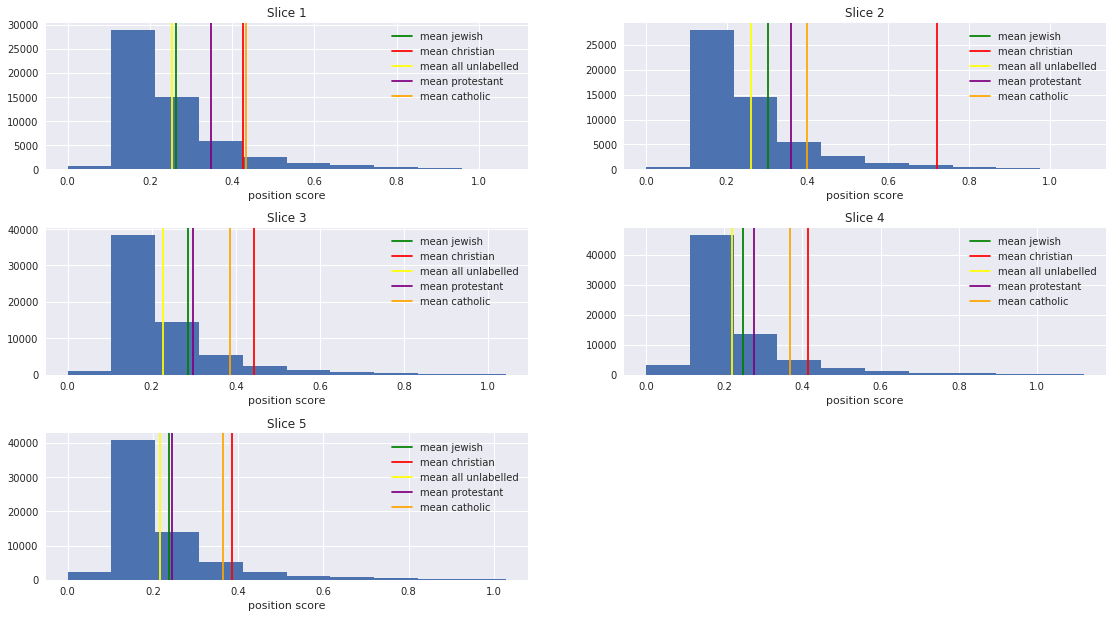

In [173]:
plt.style.use('seaborn')
fig = plt.figure(figsize=(19,17.8))

for (f,s), num in zip(all_scores, list(range(1, len(all_scores)+1))) :
    ax = fig.add_subplot(5,2,num)
#     fig, ax = plt.subplots(figsize=(9,6))
    ax.hist(f)
    ax.set_title(f'Slice {num}')
    ax.set_xlabel('position score')
    ax.axvline(s['jewish'].mean(), color='green', label='mean jewish')
    ax.axvline(s['christian'].mean(), color='red', label='mean christian')
    ax.axvline(f.mean(), color='yellow', label='mean all unlabelled')
    ax.axvline(s['protestant'].mean(), color='purple', label='mean protestant')
    ax.axvline(s['catholic'].mean(), color='orange', label='mean catholic')
    ax.legend()
    
# plt.xlabel('position score')
fig.subplots_adjust(hspace=0.4)
fig.show()

In [53]:
j_indices = [
jewish_indices_1,
jewish_indices_2,
jewish_indices_3,
jewish_indices_4,
jewish_indices_5]

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


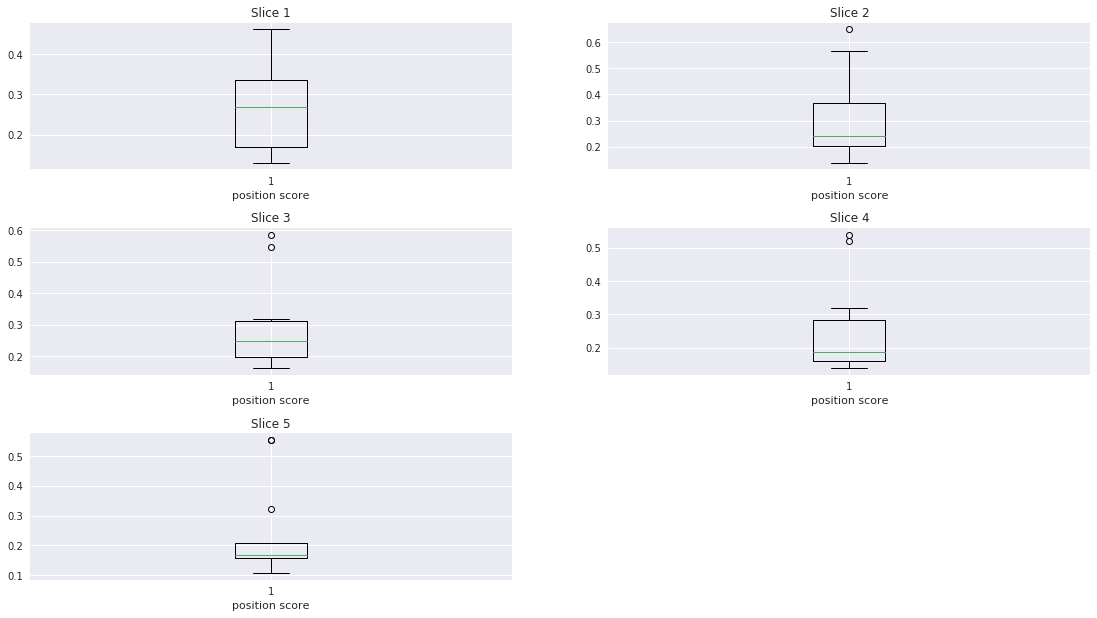

In [58]:
plt.style.use('seaborn')
fig = plt.figure(figsize=(19,17.8))

for (f,i),num in zip(all_scores, list(range(1, len(all_scores)+1))) :
    ax = fig.add_subplot(5,2,num)
#     fig, ax = plt.subplots(figsize=(9,6))
    ax.boxplot(f[i])
    ax.set_title(f'Slice {num}')
    ax.set_xlabel('position score')
#     ax.axvline(j.mean(), color='green', label='mean jewish')
#     ax.axvline(f.mean(), color='red', label='mean all unlabelled')
#     ax.axvline(c.mean(), color='yellow', label='mean christian')
    ax.legend()
    
# plt.xlabel('position score')
fig.subplots_adjust(hspace=0.4)
fig.show()

In [71]:
# Muss hier wieder eine Methode implementieren die mir die richtigen attribute indices ausgibt
# damit np.argsort Sinn macht 
rest_indices_1

i2t_slice_1_b[rest_indices_1[np.argmax(fu_1)]]

{7: 0,
 8: 1,
 9: 2,
 10: 3,
 11: 4,
 12: 5,
 13: 6,
 14: 7,
 15: 8,
 16: 9,
 17: 10,
 18: 11,
 19: 12,
 20: 13,
 21: 14,
 22: 15,
 23: 16,
 24: 17,
 25: 18,
 26: 19,
 27: 20,
 28: 21,
 29: 22,
 30: 23,
 31: 24,
 32: 25,
 33: 26,
 34: 27,
 35: 28,
 36: 29,
 37: 30,
 38: 31,
 39: 32,
 40: 33,
 41: 34,
 42: 35,
 43: 36,
 44: 37,
 45: 38,
 46: 39,
 47: 40,
 48: 41,
 49: 42,
 50: 43,
 51: 44,
 52: 45,
 53: 46,
 54: 47,
 55: 48,
 56: 49,
 57: 50,
 58: 51,
 59: 52,
 60: 53,
 61: 54,
 62: 55,
 63: 56,
 64: 57,
 65: 58,
 66: 59,
 67: 60,
 68: 61,
 69: 62,
 70: 63,
 71: 64,
 72: 65,
 73: 66,
 74: 67,
 75: 68,
 76: 69,
 77: 70,
 78: 71,
 79: 72,
 80: 73,
 81: 74,
 82: 75,
 83: 76,
 84: 77,
 85: 78,
 86: 79,
 87: 80,
 88: 81,
 89: 82,
 90: 83,
 91: 84,
 92: 85,
 93: 86,
 94: 87,
 95: 88,
 96: 89,
 97: 91,
 98: 92,
 99: 93,
 100: 94,
 101: 95,
 102: 96,
 103: 97,
 104: 98,
 105: 99,
 106: 100,
 107: 101,
 108: 102,
 109: 103,
 110: 104,
 111: 105,
 112: 106,
 113: 107,
 114: 108,
 115: 109,
 116: 

#### Similarity based on PPMI values

In [12]:
# Compute word similarity with sparse count matrix
def ww_sim(word, mat, tok2indx, indx2tok, topn=10):
    """Calculate topn most similar words to word"""
    indx = tok2indx[word]
    if isinstance(mat, sparse.csr_matrix):
        v1 = mat.getrow(indx)
    else:
        v1 = mat[indx:indx+1, :]
    sims = cosine_similarity(mat, v1).flatten()
    #dists = cosine_distances(mat, v1).flatten()
#     dists = euclidean_distances(mat, v1).flatten()
    sindxs = np.argsort(-sims)
    sim_word_scores = [(indx2tok[sindx], sims[sindx]) for sindx in sindxs[0:topn]]
    return sim_word_scores

In [9]:
def similarity(word1, word2, mat, tok2indx, indx2tok, topn=10):
    indx1 = tok2indx[word1]
    indx2 = tok2indx[word2]
    if isinstance(mat, sparse.csr_matrix):
        v1 = mat.getrow(indx1)
        v2 = mat.getrow(indx2)
    else:
        v1 = mat[indx1:indx1+1, :]
        v1 = mat[indx2:indx2+1, :]
        
    sim = cosine_similarity(v2, v1)
    print(sims)
    #dists = cosine_distances(mat, v1).flatten()
#     dists = euclidean_distances(mat, v1).flatten()
#     sindxs = np.argsort(-sims)
#     sim_word_scores = [(indx2tok[sindx], sims[sindx]) for sindx in sindxs[0:topn]]
    return sim